# 問7.Newral Style Transfer
Neural Style Transferの日本語解説を読みましょう． 実際にオープンソースで試してみましょう．


In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import time
import os

os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

In [33]:
from __future__ import print_function
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
from PIL import Image
import matplotlib.pyplot as plt
 
import torchvision.transforms as transforms
import torchvision.models as models
 
import copy

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [35]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu
 
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("./monet.jpg")
content_img = image_loader("./pg13.jpg")

print(style_img.size())
print(content_img.size())
assert style_img.size() == content_img.size(), "we need to import style and content images of the same size"

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


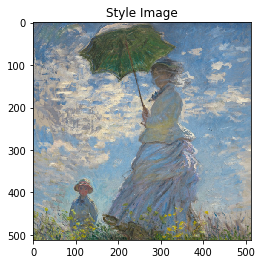

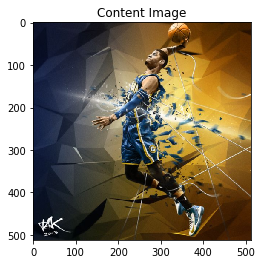

In [36]:
unloader = transforms.ToPILImage()  # reconvert into PIL image
 
plt.ion()
 
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
 
 
plt.figure()
imshow(style_img, title='Style Image')
 
plt.figure()
imshow(content_img, title='Content Image')

In [37]:
class ContentLoss(nn.Module):
 
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # 勾配を動的に計算するツリーから，対象コンテンツを切り離す
        # 明示的な値であり，変数ではない．
        # でないと，criterionの順伝播メソッドは，エラーを返す
        self.target = target.detach()
 
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

重要: 上記モジュールは ContentLoss と名前付けられていますが、それは真の PyTorch 損失関数ではありません。貴方のコンテンツ損失を PyTorch 損失関数として定義することを望む場合、backward メソッドで勾配を手動で再計算/実装するために PyTorch autograd 関数を作成しなければなりません。

### スタイル損失
スタイル損失モジュールはコンテンツ損失モジュールと同様に実装されます。それは層のスタイル損失を計算するネットワークの透過層として機能します。スタイル損失を計算するために、グラム行列 $G_{XL}$ を計算する必要があります。グラム行列は与えられた行列をその転置行列により乗算した結果です。このアプリケーションでは与えられた行列は 層 $L$ の特徴マップ $F_{XL}$ の reshape されたバージョンです。$F_{XL}$ は $\hat{F}_{XL}$、$K$ x $N$ 行列を形成するために reshape されます、ここで $K$ は層 $L$ の特徴マップの数で $N$ は任意のベクトル化された特徴マップ $F_{XL}^k$ の長さです。例えば、$\hat{F}_{XL}$ の最初の行は最初のベクトル化された特徴マップ $F_{XL}^1$ に対応します。

最後に、グラム行列は各要素を行列の要素の総数により除算することで正規化されなければなりません。この正規化は巨大な $N$ 次元を持つ $\hat{F}_{XL}$ 行列がグラム行列でより大きな値を生成するという事実を妨げます。これらのより巨大な値は勾配降下の間に (プーリング層の前の) 最初の層により大きなインパクトを持つこと引き起こします。スタイル特徴はネットワークのより深い層にありがちですのでこの正規化ステップは重要です。

In [38]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)
 
    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
 
    G = torch.mm(features, features.t())  # compute the gram product
 
    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

スタイル損失モジュールはコンテンツ損失モジュールのように殆ど正確に (同じに) 見えます。

スタイル距離はまた $G_{XL}$ と $G_{SL}$ 間の平均二乗誤差 (= mean square error) を使用して計算されます。

In [39]:
class StyleLoss(nn.Module):
 
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
 
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

### モデルをインポートする
今は事前訓練されたニューラルネットワークをインポートする必要があります。ペーパーで使用されたもののような 19 層 VGG ネットワークを使用します。

VGG の PyTorch の実装は 2 つのチャイルド Sequential モジュールに分割されたモジュールです : (畳み込みとプーリング層を含む) 特徴、そして (完全結合層を含む) 分類器です。私達は特徴モジュールを使用します、何故ならばコンテンツとスタイル損失を計測するために個々の畳み込み層の出力が必要だからです。幾つかの層は訓練の間に評価とは異なる動作を持ちますので、ネットワークを .eval() を使用して評価モードに設定しなければなりません。

In [40]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [41]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
 
# 入力画像を正規化するモジュールを作成し，nn.Sequentialに組み込む
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
 
    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

Sequential モジュールは子モジュールの順序付けられたリストを含みます。

- 例えば、vgg19.features は深さの正しい順序で整列されたシークエンス (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…) を含みます。コンテンツ損失とスタイル損失層を (それらが検出している) 畳み込み層直後に追加する必要があります。
- これを行なうために正しく挿入されたコンテンツ損失とスタイル損失モジュールを持つ新しい Sequential モジュールを作成しなければなりません。

In [42]:
# スタイル/コンテンツ損失を計算するために必要な深さのレイヤ
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
 
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
 
    # 正規化モジュール
    normalization = Normalization(normalization_mean, normalization_std).to(device)
 
    # 連番アクセスを有する，または，内容／スタイル損失をリスト化する目的
    content_losses = []
    style_losses = []
 
    # CNNがnn.Sequencialと仮定して，順次実行されるnn.Sequentialモジュールを新規作成
    model = nn.Sequential(normalization)
 
    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # in-placeバージョンは内容損失及びスタイル損失と上手く適合しません．
            # そのため，out-of-placeバージョンと置き換えます．
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
 
        model.add_module(name, layer)
 
        if name in content_layers:
            # 内容損失を追加
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
 
        if name in style_layers:
            # スタイル損失を追加
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
 
    # 最後のコンテンツとスタイルロスの後のレイヤーをトリムします
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
 
    model = model[:(i + 1)]
 
    return model, style_losses, content_losses

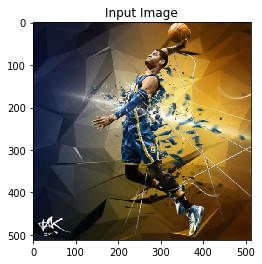

In [43]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)
 
# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [44]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [45]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)
 
    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:
 
        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)
 
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
 
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
 
            style_score *= style_weight
            content_score *= content_weight
 
            loss = style_score + content_score
            loss.backward()
 
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()
 
            return style_score + content_score
 
        optimizer.step(closure)
 
    # a last correction...
    input_img.data.clamp_(0, 1)
 
    return input_img

Building the style transfer model..
Optimizing..


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


run [50]:
Style Loss : 92.138054 Content Loss: 13.273747

run [100]:
Style Loss : 23.834959 Content Loss: 11.734038

run [150]:
Style Loss : 12.651909 Content Loss: 9.334687

run [200]:
Style Loss : 6.010113 Content Loss: 7.886152

run [250]:
Style Loss : 2.712884 Content Loss: 6.525239

run [300]:
Style Loss : 1.521335 Content Loss: 5.644721



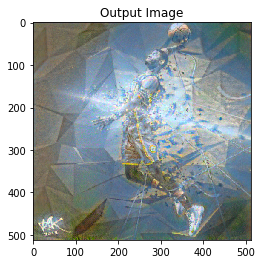

In [46]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
 
plt.figure()
imshow(output, title='Output Image')
 
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [47]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
#   tensor  
#   PIL    
def tensor_to_PIL(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    return image

temp = tensor_to_PIL(output)
temp.save("./mo13.jpg")